In [23]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import copy
from astropy.io import fits

from EightBitTransit.cTransitingImage import TransitingImage
from EightBitTransit.inversion import *
from EightBitTransit.misc import *

import scipy.interpolate as interp

%matplotlib inline

/Users/piperfrances/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':
/Users/piperfrances/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  del sys.path[0]


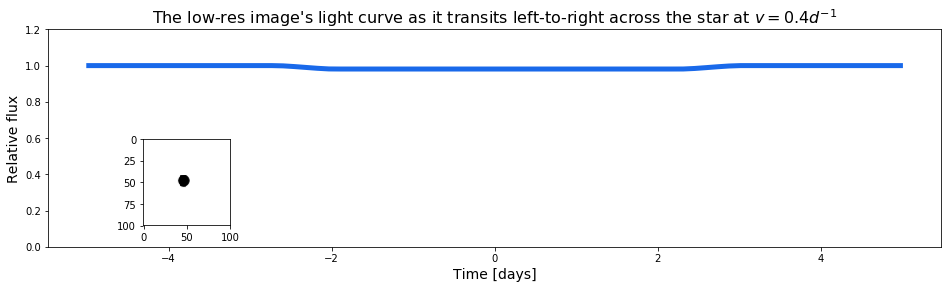

In [2]:
# extract a known planet from a simulated light curve!
times = np.linspace(-35.,35.,500)
planet_lowres_SItitle = TransitingImage(imfile="/Users/piperfrances/BSRC/code/ref_planet_larger.png",
                                    lowres=100,
                                    lowrestype="mean", # Calculate the lower-resolution version of the image by averaging "neighborhoods" of pixels in the high-res image.
                                    lowresround=False, # Let the resulting low-res pixel values take on intermediate values between 0 and 1, i.e. don't round them to 0 or 1.
                                    v=0.4,
                                    t_ref=0.,
                                    t_arr=times)
#lowres_SItitle.plot_grid()
#print np.shape(lowres_SItitle.opacitymat)
    
planet_lowres_SItitle_LC, overlapTimes = planet_lowres_SItitle.gen_LC(t_arr=times) 
    
fig, ax = plt.subplots(1,1,figsize=(16,4))
ax = plt.axes()
ax.plot(overlapTimes,planet_lowres_SItitle_LC,color="#1969ea",ls="-",lw=5)
ax.set_ylim(0.0,1.2)
plt.xlabel("Time [days]",fontsize=14)
plt.ylabel("Relative flux",fontsize=14)
plt.title(r"The low-res image's light curve as it transits left-to-right across the star at $v = 0.4 d^{-1}$",fontsize=16)
ax1 = plt.axes([.095, .2, 0.3, 0.3])
ax1.imshow(planet_lowres_SItitle.opacitymat,cmap="Greys",aspect="equal",origin="upper",interpolation='none',vmin=0.,vmax=1.)
#filename = "/Users/piperfrances/BSRC/code/results_subtract_artifacts/1"
#plt.savefig(filename, fmt="png")
plt.show()
plt.close()

In [28]:
planet_interp_LC = interp.interp1d(np.arange(planet_lowres_SItitle_LC.size),planet_lowres_SItitle_LC)
truth_LC = planet_interp_LC(np.linspace(0,planet_lowres_SItitle_LC.size-1,times.size))

truth_LC_err = np.linspace(0, 0, truth_LC.size)

In [ ]:
LDlaw="quadratic"
LDCs = [0.34, 0.34]

test_vs = np.array((0.4,0.8,1.6,3.2))

ref = np.int(np.ceil((times.size/2)))

t_ref=times[ref]

path = "/Users/piperfrances/BSRC/code/ref_planet_LC_to_MGSTRCT"

fig = plt.figure(figsize=(16,3*len(test_vs)))
gs = gridspec.GridSpec(len(test_vs)*5, 7)

maxmax=0.

for i in range(0, len(test_vs)):
    v = test_vs[i]
    print "v = {0}".format(v)
    
    # N chosen to be the highest possible integer value at each v, given that M is calculated from v (see below)
    # and that N * M cannot exceed the number of observed data points.
    if v < 1.0:
        N = 10
    elif v < 2.0:
        N = 7
    else:
        N = 5
    
    w = 2./N
    M = int(np.ceil((2.*(t_ref - np.min(times))*v - 2.)/w))
    
    
    ti = TransitingImage(opacitymat=np.zeros((N,M)), LDlaw=LDlaw, LDCs=LDCs, v=v, t_ref=t_ref, t_arr=times)
    trial_LC, overlapTimes = ti.gen_LC(times)
    
    tMin = t_ref - (2. + ti.w*M)/(2.*v)
    tMax = t_ref + (2. + ti.w*M)/(2.*v)
    overlappingTimesMask = (times > tMin) & (times < tMax)
        
    overlappingObsLC = truth_LC[overlappingTimesMask]
    overlappingObsLCerr = truth_LC_err[overlappingTimesMask]
    
    # Since the light blocked by each pixel at each time step does not depend on the pixel's opacity, we can calculate it in advance to save time.
    try:
        LCdecs = np.load(path+"_LCdecs_v{0}_N{1}_M{2}.npy".format(v, N, M))
    except IOError:
        LCdecs = calculateLCdecrements(N=N,M=M,LDlaw=LDlaw, LDCs=LDCs, v=v, t_ref=t_ref, times=overlapTimes)
        np.save(path+"_LCdecs_v{0}_N{1}_M{2}.npy".format(v, N, M), LCdecs)
   
    arcAvg_ax = plt.subplot(gs[5*i, 0:5])
    SART_ax = plt.subplot(gs[5*i+1, 0:5])
    pars_ax = plt.subplot(gs[5*i+2, 0:5])
    comb_ax = plt.subplot(gs[5*i+3, 0:5])
    
    LC_ax = plt.subplot(gs[5*i:5*i+4, 5:])
    
    #Arc-averaging
    try: 
        arcAvg = np.load(path+"_arcAvg_v{0}_N{1}_M{2}.npy".format(v, N, M))
    except IOError:
        avgBasis = makeArcBasisAverage(N=N, M=M, t_ref=t_ref, v=v, LDlaw=LDlaw, LDCs=LDCs, times=overlapTimes, LCdecrements=LCdecs, obsLC=overlappingObsLC, obsLCerr=overlappingObsLCerr)
        arcAvg = np.mean(avgBasis,axis=0)
        np.save(path+"_arcAvg_v{0}_N{1}_M{2}.npy".format(v, N, M), arcAvg)

    arcAvg = arcAvg.reshape(N,M)
    arcAvg = ((arcAvg + arcAvg[::-1,:])/2.)
    
    arcAvg_ti = TransitingImage(opacitymat=arcAvg, LDlaw=LDlaw, LDCs=LDCs, v=v, t_ref=t_ref, t_arr=overlapTimes)
    arcAvg_LC, overlapTimes = arcAvg_ti.gen_LC(overlapTimes)
    
    arcAvg = renormBasis(arcAvg,arcAvg_LC,truth_LC)
    arcAvg_ti = TransitingImage(opacitymat=arcAvg, LDlaw=LDlaw, LDCs=LDCs, v=v, t_ref=t_ref, t_arr=overlapTimes)
    arcAvg_LC, overlapTimes = arcAvg_ti.gen_LC(overlapTimes)
    
    if np.max(arcAvg) > maxmax:
        maxmax = np.max(arcAvg)

    #SART
    try:
        raveledtau = np.genfromtxt(path+"_v{0}_quadraticLD_10000_N{1}_M{2}_taus_short.txt".format(v, N, M))
    except IOError:
        SARTgrid = invertLC(N=N,M=M, v=v, t_ref=t_ref, t_arr=overlapTimes, method="SART",
                            obsLC=overlappingObsLC, obsLCerr=overlappingObsLCerr,
                            LDlaw=LDlaw,LDCs=LDCs,
                            **{"n_iter":10000,"filename":"{0}{1}_quadraticLD_{2}_N{3}_M{4}".format("./boyajiansStar_dip5_v", v, 10000, N, M),"initstate":"uniform"})
        raveledtau = np.genfromtxt(path+"_v{0}_quadraticLD_10000_N{1}_M{2}_taus.txt".format(v, N, M))[-1]
    
    if (N>1) & (N%2 == 0): #N even
        #raveledtau = top pixels only 
        raveledtauHalf = np.reshape(copy.deepcopy(raveledtau), (int(N/2), M))
        raveledtau = np.zeros((N, M))
        raveledtau[0:int(N/2)] = raveledtauHalf
        for rowIdx in np.arange(N-1, int(N/2) - 1, -1):
            raveledtau[rowIdx] = raveledtauHalf[N - rowIdx - 1]
            
    elif (N>1) & (N%2 != 0):
        #raveledtau = top pixels + 1 row only 
        raveledtauHalf = np.reshape(copy.deepcopy(raveledtau), (int((N-1)/2 + 1), M))
        raveledtau = np.zeros((N, M))
        raveledtau[0:int((N-1)/2 + 1)] = raveledtauHalf
        for rowIdx in np.arange(N-1, int((N-1)/2), -1):
            raveledtau[rowIdx] = raveledtauHalf[N - rowIdx - 1]
    
    SART = raveledtau/2.
    SART = arcRearrange(grid=SART, v=v, t_ref=t_ref, times=overlapTimes, LDlaw=LDlaw, LDCs=LDCs)
    SART = arcRearrange(grid=SART, v=v, t_ref=t_ref, times=overlapTimes, LDlaw=LDlaw, LDCs=LDCs)
    
    SART_ti = TransitingImage(opacitymat=SART, LDlaw=LDlaw, LDCs=LDCs, v=v, t_ref=t_ref, t_arr=overlapTimes)
    SART_LC, overlapTimes = SART_ti.gen_LC(overlapTimes)
    
    #deal with edge effects: edge pixels can sometimes artificially blow up to large opaicty values because their overlap areas are very small.
    if (v == 0.8):
        SART[:,0:6] = 0.
        
    if (v == 1.6):
        SART[:,0:12] = 0.
    
    if (v == 3.2):
        SART[:,0:20] = 0.
        
    if (v == 6.4):
        SART[:,0:42] = 0.
    
    SART = renormBasis(SART, SART_LC, truth_LC)
    SART_ti = TransitingImage(opacitymat=SART, LDlaw=LDlaw, LDCs=LDCs, v=v, t_ref=t_ref, t_arr=overlapTimes)
    SART_LC, overlapTimes = SART_ti.gen_LC(overlapTimes)
    
    if np.max(SART) > maxmax:
        maxmax = np.max(SART)
    
    #dF/dt parsimony
    try: 
        pars = np.load(path+"_arcParsimony_v{0}_N{1}_M{2}.npy".format(v, N, M))
    except IOError:
        parsBasis = makeArcBasisParsimony(N=N, M=M, t_ref=t_ref, v=v, LDlaw=LDlaw, LDCs=LDCs, times=overlapTimes, LCdecrements=LCdecs, obsLC=overlappingObsLC, obsLCerr=overlappingObsLCerr)
        pars = np.mean(parsBasis,axis=0)
        np.save(path+"_arcParsimony_v{0}_N{1}_M{2}.npy".format(v, N, M), pars)
    
    pars = pars.reshape(N,M)
    pars = ((pars + pars[::-1,:])/2.)
    
    pars_ti = TransitingImage(opacitymat=pars, LDlaw=LDlaw, LDCs=LDCs, v=v, t_ref=t_ref, t_arr=overlapTimes)
    pars_LC, overlapTimes = pars_ti.gen_LC(overlapTimes)
    
    pars = renormBasis(pars,pars_LC,truth_LC)
    pars_ti = TransitingImage(opacitymat=pars, LDlaw=LDlaw, LDCs=LDCs, v=v, t_ref=t_ref, t_arr=overlapTimes)
    pars_LC, overlapTimes = pars_ti.gen_LC(overlapTimes)
    
    if np.max(pars) > maxmax:
        maxmax = np.max(pars)
    
    #arc combinatorics
    try:
        comb = np.load(path+"_arcCombinatorics_v{0}_N{1}_M{2}.npy".format(v, N, M))
    except IOError:
        combBasis = makeArcBasisCombinatoric(N=N, M=M, t_ref=t_ref, v=v, LDlaw=LDlaw, LDCs=LDCs, times=overlapTimes, LCdecrements=LCdecs, obsLC=overlappingObsLC, obsLCerr=overlappingObsLCerr)
        comb = np.mean(combBasis,axis=0)
        np.save(path+"_arcCombinatorics_v{0}_N{1}_M{2}.npy".format(v, N, M), comb)
    
    comb = comb.reshape(N,M)
    comb = ((comb + comb[::-1,:])/2.)
    
    comb_ti = TransitingImage(opacitymat=comb, LDlaw=LDlaw, LDCs=LDCs, v=v, t_ref=t_ref, t_arr=overlapTimes)
    comb_LC, overlapTimes = comb_ti.gen_LC(overlapTimes)
    
    comb = renormBasis(comb,comb_LC,truth_LC)
    comb_ti = TransitingImage(opacitymat=comb, LDlaw=LDlaw, LDCs=LDCs, v=v, t_ref=t_ref, t_arr=overlapTimes)
    comb_LC, overlapTimes = comb_ti.gen_LC(overlapTimes)
    
    methodList=["Arc-averaging","SART","dF/dt parsimony","Arc combinatorics"]
    RMSarr = np.array((RMS(overlappingObsLC,overlappingObsLCerr,arcAvg_LC),RMS(overlappingObsLC,overlappingObsLCerr,SART_LC),RMS(overlappingObsLC,overlappingObsLCerr,pars_LC),RMS(overlappingObsLC,overlappingObsLCerr,comb_LC)))
    
    bestMethod = methodList[np.argmin(RMSarr)]
    
    print "lowest-RMS method is: {0}".format(bestMethod)
    
    if np.max(comb) > maxmax:
        maxmax = np.max(comb)
    
    
    #plot images
    arcAvgImg = arcAvg_ax.imshow(arcAvg, cmap='Greys', interpolation='nearest',vmin=0.,vmax=maxmax)
    SARTImg = SART_ax.imshow(SART, cmap='Greys', interpolation='nearest',vmin=0.,vmax=maxmax)
    parsImg = pars_ax.imshow(pars, cmap='Greys', interpolation='nearest',vmin=0.,vmax=maxmax)
    combImg = comb_ax.imshow(comb, cmap='Greys', interpolation='nearest',vmin=0.,vmax=maxmax)
    
    #plot light curves
    LC_ax.plot(overlapTimes-t_ref, overlappingObsLC,'k-',lw=3,label='Truth')
    LC_ax.plot(overlapTimes-t_ref, arcAvg_LC,ls='-',lw=1.5,color='#F90000',label='Arc-averaging')
    LC_ax.plot(overlapTimes-t_ref, SART_LC,ls='-',lw=1.5,color='#0030FF',label='SART')
    LC_ax.plot(overlapTimes-t_ref, pars_LC,ls='-',lw=1.5,color='#F77F00',label='dF/dt parsimony')
    LC_ax.plot(overlapTimes-t_ref, comb_LC,ls='-',lw=1.5,color='#FCBF49',label='Arc combinatorics')
    LC_ax.set_ylim(np.min(truth_LC)-0.01,1.01)
    LC_ax.set_xlim(-4.85-t_ref, 6.01)
    
    #plot formatting
    if i==3:
        arcAvg_ax.plot(np.array((-5)), np.array((N/2.)), marker='o',mec='k',mew=2,color='#F90000',ms=15, clip_on=False)
        SART_ax.plot(np.array((-5)), np.array((N/2.)), marker='o',mec='k',mew=2,color='#0030FF',ms=15, clip_on=False)
        pars_ax.plot(np.array((-5)), np.array((N/2.)), marker='o',mec='k',mew=2,color='#F77F00',ms=15, clip_on=False)
        comb_ax.plot(np.array((-5)), np.array((N/2.)), marker='o',mec='k',mew=2,color='#FCBF49',ms=15, clip_on=False)
    
    for ax in [arcAvg_ax, SART_ax, pars_ax, comb_ax]:
        ax.set_xlim(-0.5,M-0.5)
        ax.set_ylim(-0.5,N-0.5)
        ax.set_xticks([])
        ax.set_yticks([])
    
    LC_ax.set_xticks(np.arange(-6,7,2))
    LC_ax.set_yticks(np.arange(0.85,1.01,0.05))  
    LC_ax.set_xticklabels([])
    LC_ax.set_yticklabels([])  
    LC_ax.yaxis.tick_right()
    
plt.show()
#plt.savefig("./boyajiansStar_dip5.pdf",fmt="pdf")


v = 0.4


/Users/piperfrances/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in true_divide
/Users/piperfrances/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in true_divide


In [37]:
import tqdm as tqdm

In [4]:
hdul = fits.open('hlsp_eleanor_tess_ffi_tic294970584_s09_tess_v1.0.4_lc.fits')

In [17]:
times = hdul[1].data['TIME']

In [18]:
truth_LC = hdul[1].data['PSF_FLUX']

In [23]:
truth_LC_err = hdul[1].data['FLUX_ERR']

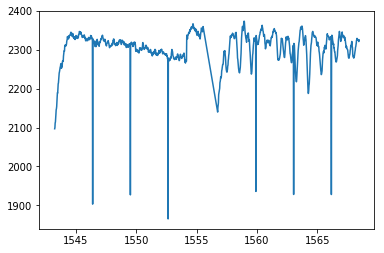

In [24]:
plt.plot(times, truth_LC)

In [26]:
len(truth_LC)

1154

In [20]:
# Here, we present an inversion of Dip 5 of Boyajian's Star, by all four of the available inversion algorithm.
# This code reproduces figure 12 of Sandford et al. 2018.

# Limb-darkening coefficients interpolated from Sing (2010):
LDlaw="quadratic"
LDCs = [0.34, 0.34] #waiting for Ann Marie to let me know
# according to one paper I read, for a 6500K star, the LDCs should add to ~0.68

v = 0.4


/Users/piperfrances/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


ValueError: Big-endian buffer not supported on little-endian compiler

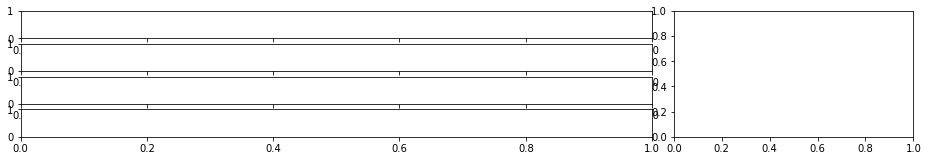

In [43]:
test_vs = np.array((0.4,0.8,1.6,3.2))

t_ref=times[500]

fig = plt.figure(figsize=(16,3*len(test_vs)))
gs = gridspec.GridSpec(len(test_vs)*5, 7)

maxmax=0.

for i in range(0, len(test_vs)):
    v = test_vs[i]
    print "v = {0}".format(v)
    
    # N chosen to be the highest possible integer value at each v, given that M is calculated from v (see below)
    # and that N * M cannot exceed the number of observed data points.
    if v < 1.0:
        N = 10
    elif v < 2.0:
        N = 7
    else:
        N = 5
    
    w = 2./N
    M = int(np.ceil((2.*(t_ref - np.min(times))*v - 2.)/w))
    
    
    ti = TransitingImage(opacitymat=np.zeros((N,M)), LDlaw=LDlaw, LDCs=LDCs, v=v, t_ref=t_ref, t_arr=times)
    trial_LC, overlapTimes = ti.gen_LC(times)
    
    tMin = t_ref - (2. + ti.w*M)/(2.*v)
    tMax = t_ref + (2. + ti.w*M)/(2.*v)
    overlappingTimesMask = (times > tMin) & (times < tMax)
        
    overlappingObsLC = truth_LC[overlappingTimesMask]
    overlappingObsLCerr = truth_LC_err[overlappingTimesMask]
    
    # Since the light blocked by each pixel at each time step does not depend on the pixel's opacity, we can calculate it in advance to save time.
    try:
        LCdecs = np.load("./boyajianResults/boyajiansStar_dip5_LCdecs_v{0}_N{1}_M{2}.npy".format(v, N, M))
    except IOError:
        LCdecs = calculateLCdecrements(N=N,M=M,LDlaw=LDlaw, LDCs=LDCs, v=v, t_ref=t_ref, times=overlapTimes)
        np.save("/Users/piperfrances/BSRC/code/TIC294970584/TIC294970584_LCdecs_v{0}_N{1}_M{2}.npy".format(v, N, M), LCdecs)
   
    arcAvg_ax = plt.subplot(gs[5*i, 0:5])
    SART_ax = plt.subplot(gs[5*i+1, 0:5])
    pars_ax = plt.subplot(gs[5*i+2, 0:5])
    comb_ax = plt.subplot(gs[5*i+3, 0:5])
    
    LC_ax = plt.subplot(gs[5*i:5*i+4, 5:])
    
    #Arc-averaging
    try: 
        arcAvg = np.load("./boyajianResults/boyajiansStar_dip5_arcAvg_v{0}_N{1}_M{2}.npy".format(v, N, M))
    except IOError:
        avgBasis = makeArcBasisAverage(N=N, M=M, t_ref=t_ref, v=v, LDlaw=LDlaw, LDCs=LDCs, times=overlapTimes, LCdecrements=LCdecs, obsLC=overlappingObsLC, obsLCerr=overlappingObsLCerr)
        arcAvg = np.mean(avgBasis,axis=0)
        np.save("/Users/piperfrances/BSRC/code/TIC294970584/TIC294970584_arcAvg_v{0}_N{1}_M{2}.npy".format(v, N, M), arcAvg)

    arcAvg = arcAvg.reshape(N,M)
    arcAvg = ((arcAvg + arcAvg[::-1,:])/2.)
    
    arcAvg_ti = TransitingImage(opacitymat=arcAvg, LDlaw=LDlaw, LDCs=LDCs, v=v, t_ref=t_ref, t_arr=overlapTimes)
    arcAvg_LC, overlapTimes = arcAvg_ti.gen_LC(overlapTimes)
    
    arcAvg = renormBasis(arcAvg,arcAvg_LC,truth_LC)
    arcAvg_ti = TransitingImage(opacitymat=arcAvg, LDlaw=LDlaw, LDCs=LDCs, v=v, t_ref=t_ref, t_arr=overlapTimes)
    arcAvg_LC, overlapTimes = arcAvg_ti.gen_LC(overlapTimes)
    
    if np.max(arcAvg) > maxmax:
        maxmax = np.max(arcAvg)

    #SART
    try:
        raveledtau = np.genfromtxt("/Users/piperfrances/BSRC/code/TIC294970584/TIC294970584_v{0}_quadraticLD_10000_N{1}_M{2}_taus_short.txt".format(v, N, M))
    except IOError:
        SARTgrid = invertLC(N=N,M=M, v=v, t_ref=t_ref, t_arr=overlapTimes, method="SART",
                            obsLC=overlappingObsLC, obsLCerr=overlappingObsLCerr,
                            LDlaw=LDlaw,LDCs=LDCs,
                            **{"n_iter":10000,"filename":"{0}{1}_quadraticLD_{2}_N{3}_M{4}".format("./boyajiansStar_dip5_v", v, 10000, N, M),"initstate":"uniform"})
        raveledtau = np.genfromtxt("/Users/piperfrances/BSRC/code/TIC294970584/TIC294970584_v{0}_quadraticLD_10000_N{1}_M{2}_taus.txt".format(v, N, M))[-1]
    
    if (N>1) & (N%2 == 0): #N even
        #raveledtau = top pixels only 
        raveledtauHalf = np.reshape(copy.deepcopy(raveledtau), (int(N/2), M))
        raveledtau = np.zeros((N, M))
        raveledtau[0:int(N/2)] = raveledtauHalf
        for rowIdx in np.arange(N-1, int(N/2) - 1, -1):
            raveledtau[rowIdx] = raveledtauHalf[N - rowIdx - 1]
            
    elif (N>1) & (N%2 != 0):
        #raveledtau = top pixels + 1 row only 
        raveledtauHalf = np.reshape(copy.deepcopy(raveledtau), (int((N-1)/2 + 1), M))
        raveledtau = np.zeros((N, M))
        raveledtau[0:int((N-1)/2 + 1)] = raveledtauHalf
        for rowIdx in np.arange(N-1, int((N-1)/2), -1):
            raveledtau[rowIdx] = raveledtauHalf[N - rowIdx - 1]
    
    SART = raveledtau/2.
    SART = arcRearrange(grid=SART, v=v, t_ref=t_ref, times=overlapTimes, LDlaw=LDlaw, LDCs=LDCs)
    SART = arcRearrange(grid=SART, v=v, t_ref=t_ref, times=overlapTimes, LDlaw=LDlaw, LDCs=LDCs)
    
    SART_ti = TransitingImage(opacitymat=SART, LDlaw=LDlaw, LDCs=LDCs, v=v, t_ref=t_ref, t_arr=overlapTimes)
    SART_LC, overlapTimes = SART_ti.gen_LC(overlapTimes)
    
    #deal with edge effects: edge pixels can sometimes artificially blow up to large opaicty values because their overlap areas are very small.
    if (v == 0.8):
        SART[:,0:6] = 0.
        
    if (v == 1.6):
        SART[:,0:12] = 0.
    
    if (v == 3.2):
        SART[:,0:20] = 0.
        
    if (v == 6.4):
        SART[:,0:42] = 0.
    
    SART = renormBasis(SART, SART_LC, truth_LC)
    SART_ti = TransitingImage(opacitymat=SART, LDlaw=LDlaw, LDCs=LDCs, v=v, t_ref=t_ref, t_arr=overlapTimes)
    SART_LC, overlapTimes = SART_ti.gen_LC(overlapTimes)
    
    if np.max(SART) > maxmax:
        maxmax = np.max(SART)
    
    #dF/dt parsimony
    try: 
        pars = np.load("/Users/piperfrances/BSRC/code/TIC294970584/TIC294970584_arcParsimony_v{0}_N{1}_M{2}.npy".format(v, N, M))
    except IOError:
        parsBasis = makeArcBasisParsimony(N=N, M=M, t_ref=t_ref, v=v, LDlaw=LDlaw, LDCs=LDCs, times=overlapTimes, LCdecrements=LCdecs, obsLC=overlappingObsLC, obsLCerr=overlappingObsLCerr)
        pars = np.mean(parsBasis,axis=0)
        np.save("/Users/piperfrances/BSRC/code/TIC294970584/TIC294970584_arcParsimony_v{0}_N{1}_M{2}.npy".format(v, N, M), pars)
    
    pars = pars.reshape(N,M)
    pars = ((pars + pars[::-1,:])/2.)
    
    pars_ti = TransitingImage(opacitymat=pars, LDlaw=LDlaw, LDCs=LDCs, v=v, t_ref=t_ref, t_arr=overlapTimes)
    pars_LC, overlapTimes = pars_ti.gen_LC(overlapTimes)
    
    pars = renormBasis(pars,pars_LC,truth_LC)
    pars_ti = TransitingImage(opacitymat=pars, LDlaw=LDlaw, LDCs=LDCs, v=v, t_ref=t_ref, t_arr=overlapTimes)
    pars_LC, overlapTimes = pars_ti.gen_LC(overlapTimes)
    
    if np.max(pars) > maxmax:
        maxmax = np.max(pars)
    
    #arc combinatorics
    try:
        comb = np.load("/Users/piperfrances/BSRC/code/TIC294970584/TIC294970584_arcCombinatorics_v{0}_N{1}_M{2}.npy".format(v, N, M))
    except IOError:
        combBasis = makeArcBasisCombinatoric(N=N, M=M, t_ref=t_ref, v=v, LDlaw=LDlaw, LDCs=LDCs, times=overlapTimes, LCdecrements=LCdecs, obsLC=overlappingObsLC, obsLCerr=overlappingObsLCerr)
        comb = np.mean(combBasis,axis=0)
        np.save("/Users/piperfrances/BSRC/code/TIC294970584/TIC294970584_arcCombinatorics_v{0}_N{1}_M{2}.npy".format(v, N, M), comb)
    
    comb = comb.reshape(N,M)
    comb = ((comb + comb[::-1,:])/2.)
    
    comb_ti = TransitingImage(opacitymat=comb, LDlaw=LDlaw, LDCs=LDCs, v=v, t_ref=t_ref, t_arr=overlapTimes)
    comb_LC, overlapTimes = comb_ti.gen_LC(overlapTimes)
    
    comb = renormBasis(comb,comb_LC,truth_LC)
    comb_ti = TransitingImage(opacitymat=comb, LDlaw=LDlaw, LDCs=LDCs, v=v, t_ref=t_ref, t_arr=overlapTimes)
    comb_LC, overlapTimes = comb_ti.gen_LC(overlapTimes)
    
    methodList=["Arc-averaging","SART","dF/dt parsimony","Arc combinatorics"]
    RMSarr = np.array((RMS(overlappingObsLC,overlappingObsLCerr,arcAvg_LC),RMS(overlappingObsLC,overlappingObsLCerr,SART_LC),RMS(overlappingObsLC,overlappingObsLCerr,pars_LC),RMS(overlappingObsLC,overlappingObsLCerr,comb_LC)))
    
    bestMethod = methodList[np.argmin(RMSarr)]
    
    print "lowest-RMS method is: {0}".format(bestMethod)
    
    if np.max(comb) > maxmax:
        maxmax = np.max(comb)
    
    
    #plot images
    arcAvgImg = arcAvg_ax.imshow(arcAvg, cmap='Greys', interpolation='nearest',vmin=0.,vmax=maxmax)
    SARTImg = SART_ax.imshow(SART, cmap='Greys', interpolation='nearest',vmin=0.,vmax=maxmax)
    parsImg = pars_ax.imshow(pars, cmap='Greys', interpolation='nearest',vmin=0.,vmax=maxmax)
    combImg = comb_ax.imshow(comb, cmap='Greys', interpolation='nearest',vmin=0.,vmax=maxmax)
    
    #plot light curves
    LC_ax.plot(overlapTimes-t_ref, overlappingObsLC,'k-',lw=3,label='Truth')
    LC_ax.plot(overlapTimes-t_ref, arcAvg_LC,ls='-',lw=1.5,color='#F90000',label='Arc-averaging')
    LC_ax.plot(overlapTimes-t_ref, SART_LC,ls='-',lw=1.5,color='#0030FF',label='SART')
    LC_ax.plot(overlapTimes-t_ref, pars_LC,ls='-',lw=1.5,color='#F77F00',label='dF/dt parsimony')
    LC_ax.plot(overlapTimes-t_ref, comb_LC,ls='-',lw=1.5,color='#FCBF49',label='Arc combinatorics')
    LC_ax.set_ylim(np.min(truth_LC)-0.01,1.01)
    LC_ax.set_xlim(-4.85-t_ref, 6.01)
    
    #plot formatting
    if i==3:
        arcAvg_ax.plot(np.array((-5)), np.array((N/2.)), marker='o',mec='k',mew=2,color='#F90000',ms=15, clip_on=False)
        SART_ax.plot(np.array((-5)), np.array((N/2.)), marker='o',mec='k',mew=2,color='#0030FF',ms=15, clip_on=False)
        pars_ax.plot(np.array((-5)), np.array((N/2.)), marker='o',mec='k',mew=2,color='#F77F00',ms=15, clip_on=False)
        comb_ax.plot(np.array((-5)), np.array((N/2.)), marker='o',mec='k',mew=2,color='#FCBF49',ms=15, clip_on=False)
    
    for ax in [arcAvg_ax, SART_ax, pars_ax, comb_ax]:
        ax.set_xlim(-0.5,M-0.5)
        ax.set_ylim(-0.5,N-0.5)
        ax.set_xticks([])
        ax.set_yticks([])
    
    LC_ax.set_xticks(np.arange(-6,7,2))
    LC_ax.set_yticks(np.arange(0.85,1.01,0.05))  
    LC_ax.set_xticklabels([])
    LC_ax.set_yticklabels([])  
    LC_ax.yaxis.tick_right()
    
plt.show()
#plt.savefig("./boyajiansStar_dip5.pdf",fmt="pdf")


In [42]:
cd TIC294970584

/Users/piperfrances/BSRC/code/TIC294970584
